In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# ================= 1. CONFIG =================
CONFIG = {
    "feature_dir": Path("features"),
    "batch_size": 8,
    "lr": 5e-5,
    "epochs": 20,
    "d_model": 64,
    "nhead": 4,
    "num_layers": 2,
    "ssl_dim": 768,
    "sfm_dim": 7,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_path": "best_model.pth"
}

print(f"⚙️ Running on {CONFIG['device']}")

# ================= 2. GLOBAL CLASS MAP =================
TRAIN_SSL_DIR = CONFIG["feature_dir"] / "ssl" / "train"
CLASSES = sorted([d.name for d in TRAIN_SSL_DIR.iterdir() if d.is_dir()])
CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASSES)}

print(f"🎯 Classes: {CLASS_TO_IDX}")

# ================= 3. DATASET =================
class DualStreamDataset(Dataset):
    def __init__(self, split="train"):
        self.ssl_dir = CONFIG["feature_dir"] / "ssl" / split
        self.sfm_dir = CONFIG["feature_dir"] / "sfm" / split
        self.files = []

        for cls in CLASSES:
            ssl_cls = self.ssl_dir / cls
            sfm_cls = self.sfm_dir / cls

            for f in ssl_cls.glob("*.npy"):
                sfm_path = sfm_cls / f.name
                if sfm_path.exists():
                    self.files.append({
                        "ssl": f,
                        "sfm": sfm_path,
                        "label": CLASS_TO_IDX[cls]
                    })

        print(f"✅ Loaded {len(self.files)} samples for '{split}'")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        item = self.files[idx]
        ssl = torch.from_numpy(np.load(item["ssl"])).float()
        sfm = torch.from_numpy(np.load(item["sfm"])).float()
        label = torch.tensor(item["label"]).long()
        return ssl, sfm, label

def collate_fn(batch):
    ssl, sfm, labels = zip(*batch)

    ssl_pad = pad_sequence(ssl, batch_first=True, padding_value=0.0)
    sfm_pad = pad_sequence(sfm, batch_first=True, padding_value=0.0)

    lengths = torch.tensor([x.size(0) for x in ssl])
    mask = torch.arange(ssl_pad.size(1))[None, :] < lengths[:, None]

    return ssl_pad, sfm_pad, mask.bool(), torch.stack(labels)


⚙️ Running on cuda
🎯 Classes: {'Cysts_Structural': 0, 'Dysarthia': 1, 'Hyperfunctional': 2, 'Laryngitis': 3, 'Vox senilis': 4, 'parkinson': 5, 'spasmodische_dysphonie': 6}


In [6]:
# ================= 4. MODEL (CORRECTED FOR TORCH VERSION) =================
class DualStreamTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        d = CONFIG["d_model"]

        # Projections
        self.ssl_proj = nn.Linear(CONFIG["ssl_dim"], d)
        self.sfm_proj = nn.Linear(CONFIG["sfm_dim"], d)

        self.ssl_norm = nn.LayerNorm(d)
        self.sfm_norm = nn.LayerNorm(d)

        # Independent encoders (NO weight sharing)
        self.ssl_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d,
                nhead=CONFIG["nhead"],
                dim_feedforward=256,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=CONFIG["num_layers"]
        )

        self.sfm_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d,
                nhead=CONFIG["nhead"],
                dim_feedforward=256,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=CONFIG["num_layers"]
        )

        # Cross-attention (NO average_attn_weights here)
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d,
            num_heads=CONFIG["nhead"],
            batch_first=True
        )

        self.fusion_norm = nn.LayerNorm(d)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(d, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )

    def forward(self, ssl, sfm, mask):
        """
        ssl : (B, T, 768)
        sfm : (B, T, 7)
        mask: (B, T)  True = valid, False = padding
        """

        # Project + normalize
        ssl = self.ssl_norm(self.ssl_proj(ssl))
        sfm = self.sfm_norm(self.sfm_proj(sfm))

        # Encode streams
        ssl = self.ssl_encoder(ssl, src_key_padding_mask=~mask)
        sfm = self.sfm_encoder(sfm, src_key_padding_mask=~mask)

        # Cross-attention
        fused, attn_weights = self.cross_attn(
            query=ssl,
            key=sfm,
            value=sfm,
            key_padding_mask=~mask,
            need_weights=True,
            average_attn_weights=False   # ✅ correct place
        )
        # attn_weights shape: (B, nhead, T, T)

        # Residual + norm
        fused = self.fusion_norm(fused + ssl)

        # Masked pooling
        mask_exp = mask.unsqueeze(-1).float()
        pooled = (fused * mask_exp).sum(dim=1) / (mask_exp.sum(dim=1) + 1e-8)

        logits = self.classifier(pooled)
        return logits, attn_weights




In [7]:
# ================= 5. TRAINING (PURE TERMINAL OUTPUT) =================
from tqdm.std import tqdm

def train():
    train_ds = DualStreamDataset("train")
    val_ds   = DualStreamDataset("val")

    train_loader = DataLoader(
        train_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)

    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    print("\n🚀 Training Started")
    print("Epoch | Train Loss | Val Loss | Val Acc")
    print("-" * 45)

    for epoch in range(CONFIG["epochs"]):

        # ---------- TRAIN ----------
        model.train()
        train_loss = 0.0

        for ssl, sfm, mask, labels in tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{CONFIG['epochs']}",
            ncols=80,
            ascii=True
        ):
            ssl, sfm, mask, labels = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"]),
                labels.to(CONFIG["device"])
            )

            optimizer.zero_grad()
            outputs, _ = model(ssl, sfm, mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---------- VALIDATION ----------
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for ssl, sfm, mask, labels in val_loader:
                ssl, sfm, mask, labels = (
                    ssl.to(CONFIG["device"]),
                    sfm.to(CONFIG["device"]),
                    mask.to(CONFIG["device"]),
                    labels.to(CONFIG["device"])
                )

                outputs, _ = model(ssl, sfm, mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{epoch+1:>5} | {train_loss:.4f} | {val_loss:.4f} | {val_acc:.2f}%")

        # ---------- CHECKPOINT ----------
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CONFIG["checkpoint_path"])
            print("   💾 Best model saved")

    return model, history


In [8]:

# ================= 6. RUN =================
model, history = train()


✅ Loaded 14740 samples for 'train'
✅ Loaded 920 samples for 'val'

🚀 Training Started
Epoch | Train Loss | Val Loss | Val Acc
---------------------------------------------


Epoch 1/20: 100%|###########################| 1843/1843 [01:30<00:00, 20.40it/s]


    1 | 1.0033 | 0.5160 | 83.91%
   💾 Best model saved


Epoch 2/20: 100%|###########################| 1843/1843 [00:40<00:00, 45.94it/s]


    2 | 0.4972 | 0.4466 | 85.98%
   💾 Best model saved


Epoch 3/20: 100%|###########################| 1843/1843 [00:39<00:00, 46.89it/s]


    3 | 0.4351 | 0.4349 | 85.87%


Epoch 4/20: 100%|###########################| 1843/1843 [00:38<00:00, 47.38it/s]


    4 | 0.3997 | 0.4242 | 86.52%
   💾 Best model saved


Epoch 5/20: 100%|###########################| 1843/1843 [00:41<00:00, 44.15it/s]


    5 | 0.3835 | 0.4442 | 86.41%


Epoch 6/20: 100%|###########################| 1843/1843 [00:42<00:00, 43.06it/s]


    6 | 0.3625 | 0.4549 | 87.07%
   💾 Best model saved


Epoch 7/20: 100%|###########################| 1843/1843 [01:17<00:00, 23.91it/s]


    7 | 0.3449 | 0.4253 | 88.04%
   💾 Best model saved


Epoch 8/20: 100%|###########################| 1843/1843 [01:06<00:00, 27.71it/s]


    8 | 0.3318 | 0.4935 | 85.98%


Epoch 9/20: 100%|###########################| 1843/1843 [01:08<00:00, 27.08it/s]


    9 | 0.3179 | 0.4209 | 87.07%


Epoch 10/20: 100%|##########################| 1843/1843 [00:59<00:00, 30.81it/s]


   10 | 0.3061 | 0.4418 | 87.72%


Epoch 11/20: 100%|##########################| 1843/1843 [00:59<00:00, 30.74it/s]


   11 | 0.2936 | 0.4086 | 88.80%
   💾 Best model saved


Epoch 12/20: 100%|##########################| 1843/1843 [01:01<00:00, 29.93it/s]


   12 | 0.2833 | 0.4790 | 87.50%


Epoch 13/20: 100%|##########################| 1843/1843 [01:00<00:00, 30.57it/s]


   13 | 0.2724 | 0.4732 | 88.70%


Epoch 14/20: 100%|##########################| 1843/1843 [00:47<00:00, 38.59it/s]


   14 | 0.2601 | 0.4616 | 87.50%


Epoch 15/20: 100%|##########################| 1843/1843 [00:46<00:00, 40.06it/s]


   15 | 0.2510 | 0.4434 | 88.80%


Epoch 16/20: 100%|##########################| 1843/1843 [01:08<00:00, 26.99it/s]


   16 | 0.2508 | 0.4567 | 88.37%


Epoch 17/20: 100%|##########################| 1843/1843 [00:41<00:00, 43.97it/s]


   17 | 0.2389 | 0.5090 | 87.28%


Epoch 18/20: 100%|##########################| 1843/1843 [00:40<00:00, 45.82it/s]


   18 | 0.2303 | 0.4465 | 88.91%
   💾 Best model saved


Epoch 19/20: 100%|##########################| 1843/1843 [00:38<00:00, 47.42it/s]


   19 | 0.2205 | 0.5334 | 88.48%


Epoch 20/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.94it/s]


   20 | 0.2112 | 0.5591 | 88.37%


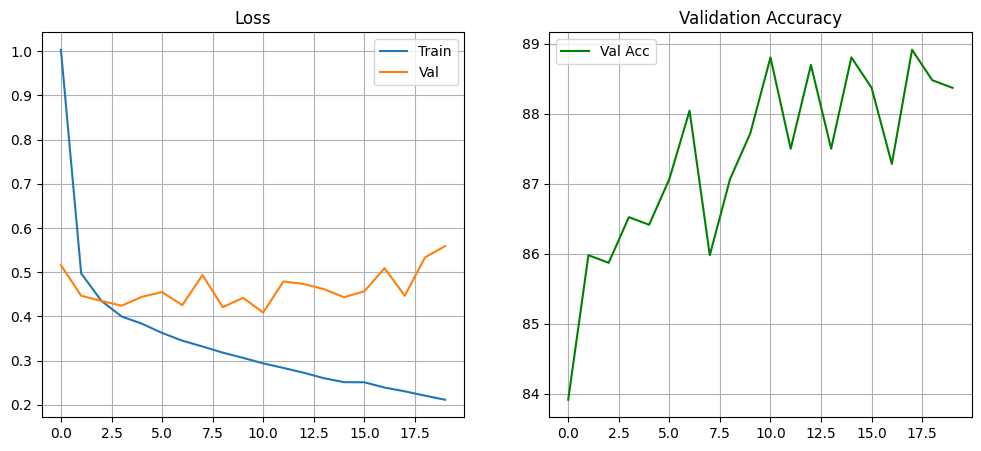

In [9]:

# ================= 7. PLOT =================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history["val_acc"], label="Val Acc", color="green")
plt.title("Validation Accuracy")
plt.legend(); plt.grid()

plt.show()



🧪 Loading TEST dataset...
✅ Loaded 925 samples for 'test'
📦 Loading best model checkpoint...
🔍 Running inference on test set...

📊 Classification Report (TEST SET):

                        precision    recall  f1-score   support

      Cysts_Structural     0.4545    0.4545    0.4545        22
             Dysarthia     0.9268    0.9048    0.9157        42
       Hyperfunctional     0.1111    0.0323    0.0500        31
            Laryngitis     0.4915    0.6905    0.5743        42
           Vox senilis     0.6796    0.7527    0.7143        93
             parkinson     0.9780    0.9896    0.9838       675
spasmodische_dysphonie     0.1250    0.0500    0.0714        20

              accuracy                         0.8832       925
             macro avg     0.5381    0.5535    0.5377       925
          weighted avg     0.8637    0.8832    0.8714       925



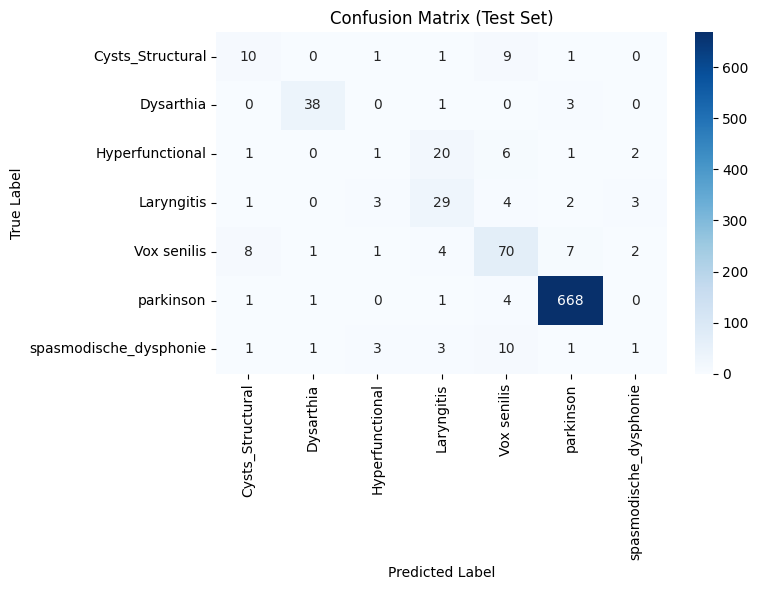

✅ Test Accuracy: 88.32%


In [10]:
# ================= 8. TESTING + CONFUSION MATRIX + CLASSIFICATION REPORT =================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_on_test():
    print("\n🧪 Loading TEST dataset...")
    test_ds = DualStreamDataset("test")
    test_loader = DataLoader(
        test_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # Load best model
    print("📦 Loading best model checkpoint...")
    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])
    checkpoint = torch.load(CONFIG["checkpoint_path"], map_location=CONFIG["device"])
    model.load_state_dict(checkpoint["model_state"] if "model_state" in checkpoint else checkpoint)
    model.eval()

    all_preds = []
    all_labels = []

    print("🔍 Running inference on test set...")
    with torch.no_grad():
        for ssl, sfm, mask, labels in test_loader:
            ssl, sfm, mask = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"])
            )

            outputs, _ = model(ssl, sfm, mask)
            preds = outputs.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ================= CLASSIFICATION REPORT =================
    print("\n📊 Classification Report (TEST SET):\n")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        digits=4
    ))

    # ================= CONFUSION MATRIX =================
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASSES,
        yticklabels=CLASSES
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

    # ================= ACCURACY =================
    acc = (all_preds == all_labels).mean() * 100
    print(f"✅ Test Accuracy: {acc:.2f}%")

    return acc, cm


# ================= RUN TEST =================
test_acc, test_cm = evaluate_on_test()


In [11]:
# ================= 9. WEIGHTED-LOSS TRAINING =================
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm.std import tqdm   # pure terminal output

def train_with_weighted_loss():
    # -------- LOAD DATA --------
    train_ds = DualStreamDataset("train")
    val_ds   = DualStreamDataset("val")

    train_loader = DataLoader(
        train_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # -------- COMPUTE CLASS WEIGHTS --------
    train_labels = [item["label"] for item in train_ds.files]
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(len(CLASSES)),
        y=np.array(train_labels)
    )

    class_weights = torch.tensor(
        class_weights, dtype=torch.float
    ).to(CONFIG["device"])

    print("⚖️ Class Weights:")
    for cls, w in zip(CLASSES, class_weights.cpu().numpy()):
        print(f"  {cls:<25} → {w:.3f}")

    # -------- MODEL --------
    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr"],
        weight_decay=1e-4
    )

    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    print("\n🚀 Training with WEIGHTED LOSS")
    print("Epoch | Train Loss | Val Loss | Val Acc")
    print("-" * 45)

    # -------- TRAINING LOOP --------
    for epoch in range(CONFIG["epochs"]):
        model.train()
        train_loss = 0.0

        for ssl, sfm, mask, labels in tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{CONFIG['epochs']}",
            ncols=80,
            ascii=True
        ):
            ssl, sfm, mask, labels = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"]),
                labels.to(CONFIG["device"])
            )

            optimizer.zero_grad()
            outputs, _ = model(ssl, sfm, mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # -------- VALIDATION --------
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for ssl, sfm, mask, labels in val_loader:
                ssl, sfm, mask, labels = (
                    ssl.to(CONFIG["device"]),
                    sfm.to(CONFIG["device"]),
                    mask.to(CONFIG["device"]),
                    labels.to(CONFIG["device"])
                )

                outputs, _ = model(ssl, sfm, mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{epoch+1:>5} | {train_loss:.4f} | {val_loss:.4f} | {val_acc:.2f}%")

        # -------- CHECKPOINT --------
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "val_acc": val_acc,
                "class_weights": class_weights.cpu().numpy(),
                "classes": CLASSES
            }, "best_model_weighted.pth")
            print("   💾 Best WEIGHTED model saved")

    return model, history


# ================= RUN WEIGHTED TRAINING =================
weighted_model, weighted_history = train_with_weighted_loss()


✅ Loaded 14740 samples for 'train'
✅ Loaded 920 samples for 'val'
⚖️ Class Weights:
  Cysts_Structural          → 6.157
  Dysarthia                 → 3.181
  Hyperfunctional           → 4.351
  Laryngitis                → 3.134
  Vox senilis               → 1.415
  parkinson                 → 0.195
  spasmodische_dysphonie    → 6.881

🚀 Training with WEIGHTED LOSS
Epoch | Train Loss | Val Loss | Val Acc
---------------------------------------------


Epoch 1/20: 100%|###########################| 1843/1843 [01:13<00:00, 25.19it/s]


    1 | 1.4210 | 0.6482 | 80.11%
   💾 Best WEIGHTED model saved


Epoch 2/20: 100%|###########################| 1843/1843 [00:47<00:00, 38.41it/s]


    2 | 1.1355 | 0.5122 | 83.37%
   💾 Best WEIGHTED model saved


Epoch 3/20: 100%|###########################| 1843/1843 [00:41<00:00, 44.31it/s]


    3 | 1.0178 | 0.4673 | 84.57%
   💾 Best WEIGHTED model saved


Epoch 4/20: 100%|###########################| 1843/1843 [00:39<00:00, 47.18it/s]


    4 | 0.9650 | 0.4524 | 85.98%
   💾 Best WEIGHTED model saved


Epoch 5/20: 100%|###########################| 1843/1843 [00:42<00:00, 42.96it/s]


    5 | 0.9358 | 0.4770 | 85.65%


Epoch 6/20: 100%|###########################| 1843/1843 [00:40<00:00, 45.61it/s]


    6 | 0.9037 | 0.4895 | 86.09%
   💾 Best WEIGHTED model saved


Epoch 7/20: 100%|###########################| 1843/1843 [00:40<00:00, 45.98it/s]


    7 | 0.8700 | 0.4191 | 86.30%
   💾 Best WEIGHTED model saved


Epoch 8/20: 100%|###########################| 1843/1843 [00:39<00:00, 46.93it/s]


    8 | 0.8528 | 0.4676 | 86.30%


Epoch 9/20: 100%|###########################| 1843/1843 [00:39<00:00, 46.99it/s]


    9 | 0.8309 | 0.4438 | 86.74%
   💾 Best WEIGHTED model saved


Epoch 10/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.70it/s]


   10 | 0.8082 | 0.5729 | 85.43%


Epoch 11/20: 100%|##########################| 1843/1843 [00:41<00:00, 44.09it/s]


   11 | 0.7685 | 0.4494 | 86.41%


Epoch 12/20: 100%|##########################| 1843/1843 [00:41<00:00, 44.92it/s]


   12 | 0.7575 | 0.4948 | 87.07%
   💾 Best WEIGHTED model saved


Epoch 13/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.27it/s]


   13 | 0.7249 | 0.4509 | 86.20%


Epoch 14/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.96it/s]


   14 | 0.7158 | 0.4972 | 87.83%
   💾 Best WEIGHTED model saved


Epoch 15/20: 100%|##########################| 1843/1843 [00:38<00:00, 48.21it/s]


   15 | 0.6744 | 0.5654 | 87.07%


Epoch 16/20: 100%|##########################| 1843/1843 [00:40<00:00, 46.04it/s]


   16 | 0.6808 | 0.6523 | 86.41%


Epoch 17/20: 100%|##########################| 1843/1843 [00:40<00:00, 45.57it/s]


   17 | 0.6624 | 0.6754 | 86.63%


Epoch 18/20: 100%|##########################| 1843/1843 [00:40<00:00, 45.81it/s]


   18 | 0.6407 | 0.5593 | 87.28%


Epoch 19/20: 100%|##########################| 1843/1843 [00:39<00:00, 47.15it/s]


   19 | 0.6498 | 0.5567 | 87.61%


Epoch 20/20: 100%|##########################| 1843/1843 [00:39<00:00, 47.01it/s]


   20 | 0.6255 | 0.6605 | 87.07%



🧪 Loading TEST dataset...
✅ Loaded 925 samples for 'test'
📦 Loading weighted model checkpoint...
🔍 Running inference on test set...

📊 Classification Report (WEIGHTED MODEL – TEST SET):

                        precision    recall  f1-score   support

      Cysts_Structural     0.4167    0.2273    0.2941        22
             Dysarthia     0.9474    0.8571    0.9000        42
       Hyperfunctional     0.3529    0.1935    0.2500        31
            Laryngitis     0.6970    0.5476    0.6133        42
           Vox senilis     0.6016    0.8280    0.6968        93
             parkinson     0.9765    0.9852    0.9808       675
spasmodische_dysphonie     0.2500    0.2000    0.2222        20

              accuracy                         0.8822       925
             macro avg     0.6060    0.5484    0.5653       925
          weighted avg     0.8749    0.8822    0.8747       925



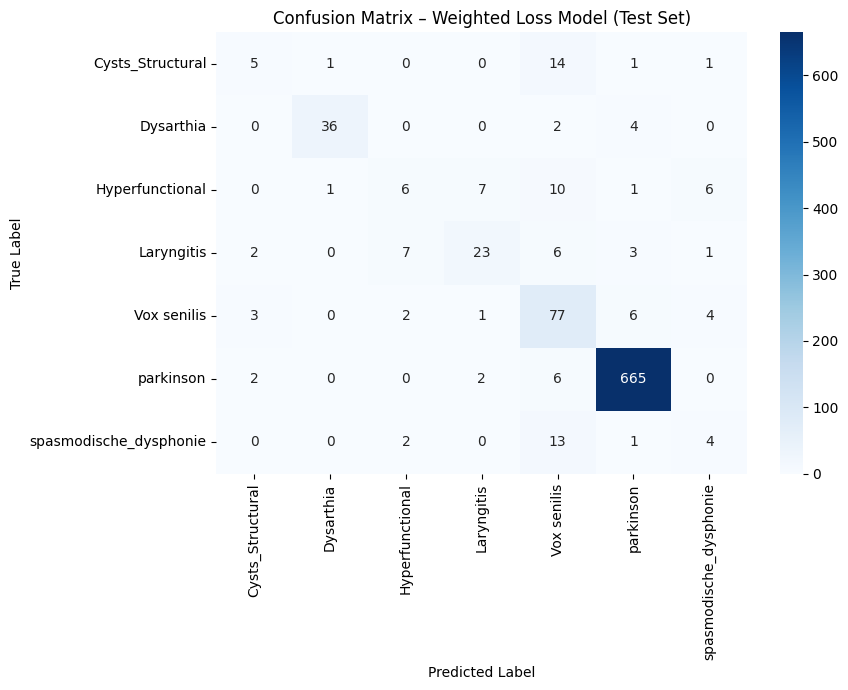

✅ Weighted Model Test Accuracy: 88.22%


In [13]:
# ================= 10. TEST WEIGHTED MODEL (FIXED TORCH 2.6+) =================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def test_weighted_model():
    print("\n🧪 Loading TEST dataset...")
    test_ds = DualStreamDataset("test")
    test_loader = DataLoader(
        test_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # -------- LOAD WEIGHTED CHECKPOINT (IMPORTANT FIX) --------
    print("📦 Loading weighted model checkpoint...")
    checkpoint = torch.load(
        "best_model_weighted.pth",
        map_location=CONFIG["device"],
        weights_only=False   # 🔴 REQUIRED in PyTorch 2.6+
    )

    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    all_preds = []
    all_labels = []

    print("🔍 Running inference on test set...")
    with torch.no_grad():
        for ssl, sfm, mask, labels in test_loader:
            ssl, sfm, mask = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"])
            )

            outputs, _ = model(ssl, sfm, mask)
            preds = outputs.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # -------- CLASSIFICATION REPORT --------
    print("\n📊 Classification Report (WEIGHTED MODEL – TEST SET):\n")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        digits=4
    ))

    # -------- CONFUSION MATRIX --------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASSES,
        yticklabels=CLASSES
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – Weighted Loss Model (Test Set)")
    plt.tight_layout()
    plt.show()

    acc = (all_preds == all_labels).mean() * 100
    print(f"✅ Weighted Model Test Accuracy: {acc:.2f}%")

    return acc, cm


# ================= RUN TEST =================
weighted_test_acc, weighted_test_cm = test_weighted_model()



🧪 Balanced Test-Time Augmentation Evaluation
✅ Loaded 925 samples for 'test'
📊 Target samples per class (balanced): 675

📊 Classification Report (Balanced TTA – Test Set)

                        precision    recall  f1-score   support

      Cysts_Structural     0.7277    0.2296    0.3491       675
             Dysarthia     0.9176    0.8578    0.8867       675
       Hyperfunctional     0.3982    0.1941    0.2610       675
            Laryngitis     0.6942    0.5481    0.6126       675
           Vox senilis     0.3159    0.8252    0.4569       675
             parkinson     0.7332    0.9852    0.8407       675
spasmodische_dysphonie     0.4126    0.2133    0.2812       675

              accuracy                         0.5505      4725
             macro avg     0.5999    0.5505    0.5269      4725
          weighted avg     0.5999    0.5505    0.5269      4725



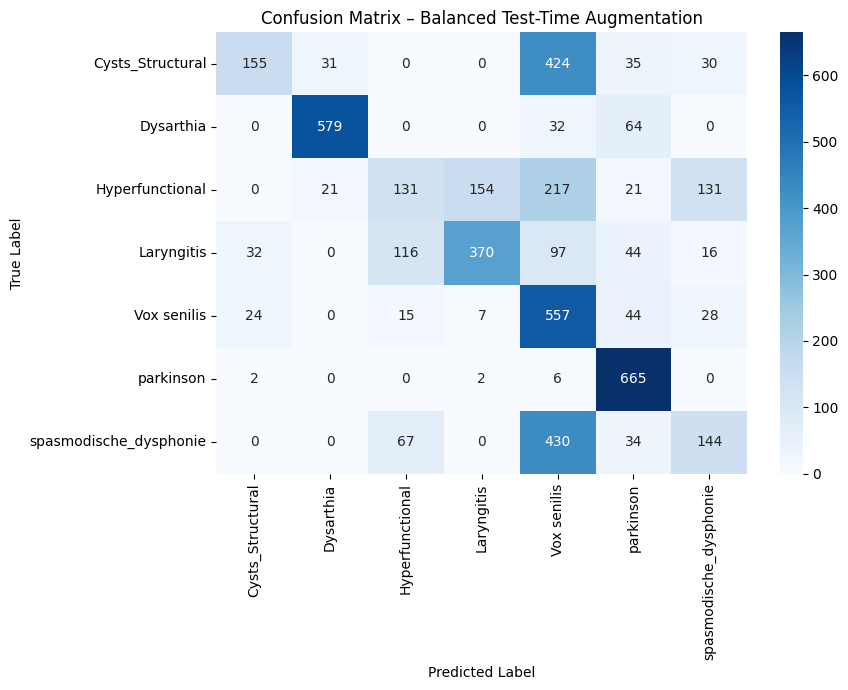

In [14]:
# ================= 11. BALANCED TEST-TIME AUGMENTATION =================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix

# ---------- FEATURE-LEVEL AUGMENTATIONS ----------
def augment_features(ssl, sfm):
    """Return list of augmented (ssl, sfm)"""
    augments = []

    # 1. Identity
    augments.append((ssl, sfm))

    # 2. Small Gaussian noise
    augments.append((
        ssl + 0.01 * torch.randn_like(ssl),
        sfm + 0.02 * torch.randn_like(sfm)
    ))

    # 3. Temporal shift
    shift = int(0.05 * ssl.shape[0])  # 5% shift
    augments.append((
        torch.roll(ssl, shifts=shift, dims=0),
        torch.roll(sfm, shifts=shift, dims=0)
    ))

    return augments


def balanced_tta_test():
    print("\n🧪 Balanced Test-Time Augmentation Evaluation")

    test_ds = DualStreamDataset("test")

    # ---------- LOAD WEIGHTED MODEL ----------
    checkpoint = torch.load(
        "best_model_weighted.pth",
        map_location=CONFIG["device"],
        weights_only=False
    )

    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    # ---------- GROUP TEST SAMPLES BY CLASS ----------
    class_groups = defaultdict(list)
    for idx, item in enumerate(test_ds.files):
        class_groups[item["label"]].append(idx)

    max_class_size = max(len(v) for v in class_groups.values())
    print(f"📊 Target samples per class (balanced): {max_class_size}")

    all_preds = []
    all_labels = []

    # ---------- BALANCED INFERENCE ----------
    with torch.no_grad():
        for cls_idx, indices in class_groups.items():

            repeat_factor = max_class_size // len(indices)
            remainder = max_class_size % len(indices)

            expanded_indices = indices * repeat_factor + indices[:remainder]

            for idx in expanded_indices:
                ssl, sfm, label = test_ds[idx]

                ssl = ssl.to(CONFIG["device"])
                sfm = sfm.to(CONFIG["device"])
                mask = torch.ones(ssl.shape[0], dtype=torch.bool, device=CONFIG["device"]).unsqueeze(0)

                # ---------- TTA ----------
                probs = []
                for ssl_aug, sfm_aug in augment_features(ssl, sfm):
                    ssl_aug = ssl_aug.unsqueeze(0)
                    sfm_aug = sfm_aug.unsqueeze(0)

                    logits, _ = model(ssl_aug, sfm_aug, mask)
                    prob = torch.softmax(logits, dim=1)
                    probs.append(prob)

                avg_prob = torch.mean(torch.stack(probs), dim=0)
                pred = avg_prob.argmax(dim=1).item()

                all_preds.append(pred)
                all_labels.append(label)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ---------- CLASSIFICATION REPORT ----------
    print("\n📊 Classification Report (Balanced TTA – Test Set)\n")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        digits=4
    ))

    # ---------- CONFUSION MATRIX ----------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASSES,
        yticklabels=CLASSES
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – Balanced Test-Time Augmentation")
    plt.tight_layout()
    plt.show()

    return cm


# ================= RUN BALANCED TTA TEST =================
balanced_cm = balanced_tta_test()


In [16]:
# ================= 13. RETRAIN FOR HIGHER ACCURACY =================
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.std import tqdm

# ---------- FOCAL LOSS ----------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(
            logits, targets, reduction="none", weight=self.alpha
        )
        pt = torch.exp(-ce)
        focal = ((1 - pt) ** self.gamma) * ce
        return focal.mean()


def retrain_high_accuracy():
    print("\n🔥 Retraining with higher capacity + focal loss")

    train_ds = DualStreamDataset("train")
    val_ds   = DualStreamDataset("val")

    train_loader = DataLoader(
        train_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # -------- MODEL --------
    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])

    # -------- CLASS WEIGHTS (light) --------
    labels = [item["label"] for item in train_ds.files]
    counts = torch.bincount(torch.tensor(labels))
    alpha = (counts.sum() / (counts + 1e-6)).to(CONFIG["device"])
    alpha = alpha / alpha.mean()   # normalize

    criterion = FocalLoss(gamma=2.0, alpha=alpha)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr"],
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CONFIG["epochs"]
    )

    best_acc = 0.0

    for epoch in range(CONFIG["epochs"]):
        model.train()
        train_loss = 0.0

        for ssl, sfm, mask, labels in tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{CONFIG['epochs']}",
            ascii=True,
            ncols=80
        ):
            ssl, sfm, mask, labels = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"]),
                labels.to(CONFIG["device"])
            )

            optimizer.zero_grad()
            logits, _ = model(ssl, sfm, mask)
            loss = criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()

        # -------- VALIDATION --------
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for ssl, sfm, mask, labels in val_loader:
                ssl, sfm, mask, labels = (
                    ssl.to(CONFIG["device"]),
                    sfm.to(CONFIG["device"]),
                    mask.to(CONFIG["device"]),
                    labels.to(CONFIG["device"])
                )

                logits, _ = model(ssl, sfm, mask)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1:02d} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                "model_state": model.state_dict(),
                "val_acc": val_acc
            }, "best_model_highacc.pth")
            print("   💾 Best high-accuracy model saved")

    return model


# ================= RUN RETRAIN =================
highacc_model = retrain_high_accuracy()



🔥 Retraining with higher capacity + focal loss
✅ Loaded 14740 samples for 'train'
✅ Loaded 920 samples for 'val'


Epoch 1/20: 100%|###########################| 1843/1843 [01:18<00:00, 23.51it/s]


Epoch 01 | Val Acc: 11.30%
   💾 Best high-accuracy model saved


Epoch 2/20: 100%|###########################| 1843/1843 [00:38<00:00, 47.32it/s]


Epoch 02 | Val Acc: 13.26%
   💾 Best high-accuracy model saved


Epoch 3/20: 100%|###########################| 1843/1843 [00:59<00:00, 30.89it/s]


Epoch 03 | Val Acc: 19.89%
   💾 Best high-accuracy model saved


Epoch 4/20: 100%|###########################| 1843/1843 [00:41<00:00, 44.58it/s]


Epoch 04 | Val Acc: 32.07%
   💾 Best high-accuracy model saved


Epoch 5/20: 100%|###########################| 1843/1843 [00:39<00:00, 46.53it/s]


Epoch 05 | Val Acc: 52.28%
   💾 Best high-accuracy model saved


Epoch 6/20: 100%|###########################| 1843/1843 [00:38<00:00, 48.01it/s]


Epoch 06 | Val Acc: 46.09%


Epoch 7/20: 100%|###########################| 1843/1843 [00:38<00:00, 48.44it/s]


Epoch 07 | Val Acc: 52.72%
   💾 Best high-accuracy model saved


Epoch 8/20: 100%|###########################| 1843/1843 [00:40<00:00, 45.56it/s]


Epoch 08 | Val Acc: 48.15%


Epoch 9/20: 100%|###########################| 1843/1843 [00:39<00:00, 46.67it/s]


Epoch 09 | Val Acc: 54.57%
   💾 Best high-accuracy model saved


Epoch 10/20: 100%|##########################| 1843/1843 [00:40<00:00, 45.89it/s]


Epoch 10 | Val Acc: 61.30%
   💾 Best high-accuracy model saved


Epoch 11/20: 100%|##########################| 1843/1843 [00:44<00:00, 41.19it/s]


Epoch 11 | Val Acc: 57.07%


Epoch 12/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.40it/s]


Epoch 12 | Val Acc: 53.91%


Epoch 13/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.43it/s]


Epoch 13 | Val Acc: 56.63%


Epoch 14/20: 100%|##########################| 1843/1843 [00:39<00:00, 46.48it/s]


Epoch 14 | Val Acc: 62.72%
   💾 Best high-accuracy model saved


Epoch 15/20: 100%|##########################| 1843/1843 [00:40<00:00, 45.89it/s]


Epoch 15 | Val Acc: 56.63%


Epoch 16/20: 100%|##########################| 1843/1843 [00:39<00:00, 47.13it/s]


Epoch 16 | Val Acc: 65.98%
   💾 Best high-accuracy model saved


Epoch 17/20: 100%|##########################| 1843/1843 [00:39<00:00, 47.06it/s]


Epoch 17 | Val Acc: 65.43%


Epoch 18/20: 100%|##########################| 1843/1843 [00:53<00:00, 34.65it/s]


Epoch 18 | Val Acc: 63.91%


Epoch 19/20: 100%|##########################| 1843/1843 [00:45<00:00, 40.10it/s]


Epoch 19 | Val Acc: 63.70%


Epoch 20/20: 100%|##########################| 1843/1843 [00:46<00:00, 39.97it/s]


Epoch 20 | Val Acc: 63.80%



🧪 Loading TEST dataset...
✅ Loaded 925 samples for 'test'
📦 Loading high-accuracy model checkpoint...
🔍 Running inference on test set...

📊 Classification Report (HIGH-ACCURACY MODEL – TEST SET):

                        precision    recall  f1-score   support

      Cysts_Structural     0.2807    0.7273    0.4051        22
             Dysarthia     0.6094    0.9286    0.7358        42
       Hyperfunctional     0.1000    0.0968    0.0984        31
            Laryngitis     0.2500    0.5714    0.3478        42
           Vox senilis     0.3515    0.7634    0.4814        93
             parkinson     1.0000    0.6741    0.8053       675
spasmodische_dysphonie     0.0952    0.1000    0.0976        20

              accuracy                         0.6595       925
             macro avg     0.3838    0.5517    0.4245       925
          weighted avg     0.8162    0.6595    0.7003       925



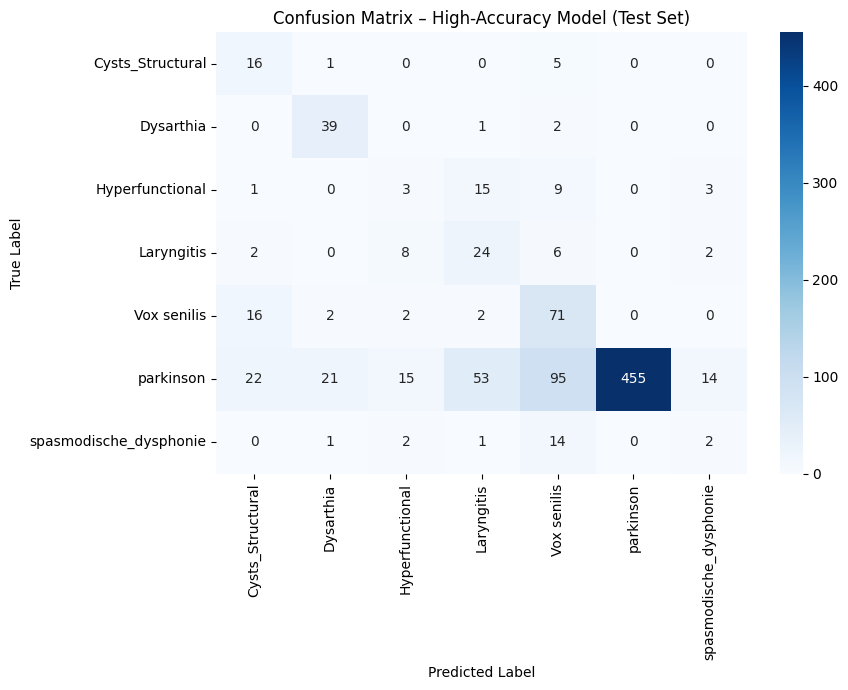

✅ High-Accuracy Model Test Accuracy: 65.95%


In [17]:
# ================= 14. TEST HIGH-ACCURACY MODEL =================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def test_high_accuracy_model():
    print("\n🧪 Loading TEST dataset...")
    test_ds = DualStreamDataset("test")
    test_loader = DataLoader(
        test_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # -------- LOAD CHECKPOINT --------
    print("📦 Loading high-accuracy model checkpoint...")
    checkpoint = torch.load(
        "best_model_highacc.pth",
        map_location=CONFIG["device"],
        weights_only=False   # PyTorch 2.6+
    )

    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    all_preds = []
    all_labels = []

    print("🔍 Running inference on test set...")
    with torch.no_grad():
        for ssl, sfm, mask, labels in test_loader:
            ssl, sfm, mask = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"])
            )

            logits, _ = model(ssl, sfm, mask)
            preds = logits.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # -------- CLASSIFICATION REPORT --------
    print("\n📊 Classification Report (HIGH-ACCURACY MODEL – TEST SET):\n")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        digits=4
    ))

    # -------- CONFUSION MATRIX --------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASSES,
        yticklabels=CLASSES
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – High-Accuracy Model (Test Set)")
    plt.tight_layout()
    plt.show()

    # -------- ACCURACY --------
    acc = (all_preds == all_labels).mean() * 100
    print(f"✅ High-Accuracy Model Test Accuracy: {acc:.2f}%")

    return acc, cm


# ================= RUN TEST =================
highacc_test_acc, highacc_test_cm = test_high_accuracy_model()


In [18]:
# ===== UPDATE CONFIG FOR FINAL RETRAIN =====
CONFIG.update({
    "d_model": 128,
    "nhead": 8,
    "epochs": 25,
    "lr": 3e-5
})

print("✅ Updated CONFIG for final retraining")


✅ Updated CONFIG for final retraining


In [19]:
# ================= FINAL RETRAIN: HIGH CAPACITY + WEIGHTED CE =================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm.std import tqdm

def retrain_final_model():
    print("\n🔥 Final retraining: High capacity + Weighted CE")

    # -------- DATA --------
    train_ds = DualStreamDataset("train")
    val_ds   = DualStreamDataset("val")

    train_loader = DataLoader(
        train_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # -------- CLASS WEIGHTS (BALANCED CE) --------
    train_labels = [item["label"] for item in train_ds.files]
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(len(CLASSES)),
        y=np.array(train_labels)
    )

    class_weights = torch.tensor(
        class_weights, dtype=torch.float
    ).to(CONFIG["device"])

    print("\n⚖️ Class Weights:")
    for cls, w in zip(CLASSES, class_weights.cpu().numpy()):
        print(f"  {cls:<25} → {w:.3f}")

    # -------- MODEL --------
    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr"],
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CONFIG["epochs"]
    )

    best_acc = 0.0

    print("\nEpoch | Train Loss | Val Acc")
    print("-" * 35)

    # -------- TRAIN LOOP --------
    for epoch in range(CONFIG["epochs"]):
        model.train()
        train_loss = 0.0

        for ssl, sfm, mask, labels in tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{CONFIG['epochs']}",
            ascii=True,
            ncols=80
        ):
            ssl, sfm, mask, labels = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"]),
                labels.to(CONFIG["device"])
            )

            optimizer.zero_grad()
            logits, _ = model(ssl, sfm, mask)
            loss = criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        scheduler.step()
        train_loss /= len(train_loader)

        # -------- VALIDATION --------
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for ssl, sfm, mask, labels in val_loader:
                ssl, sfm, mask, labels = (
                    ssl.to(CONFIG["device"]),
                    sfm.to(CONFIG["device"]),
                    mask.to(CONFIG["device"]),
                    labels.to(CONFIG["device"])
                )

                logits, _ = model(ssl, sfm, mask)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        print(f"{epoch+1:>5} | {train_loss:.4f} | {val_acc:.2f}%")

        # -------- SAVE BEST --------
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                "model_state": model.state_dict(),
                "val_acc": val_acc
            }, "best_model_final.pth")
            print("   💾 Best FINAL model saved")

    print(f"\n✅ Final best validation accuracy: {best_acc:.2f}%")
    return model


# ================= RUN FINAL RETRAIN =================
final_model = retrain_final_model()



🔥 Final retraining: High capacity + Weighted CE
✅ Loaded 14740 samples for 'train'
✅ Loaded 920 samples for 'val'

⚖️ Class Weights:
  Cysts_Structural          → 6.157
  Dysarthia                 → 3.181
  Hyperfunctional           → 4.351
  Laryngitis                → 3.134
  Vox senilis               → 1.415
  parkinson                 → 0.195
  spasmodische_dysphonie    → 6.881

Epoch | Train Loss | Val Acc
-----------------------------------


Epoch 1/25: 100%|###########################| 1843/1843 [01:20<00:00, 22.80it/s]


    1 | 1.4803 | 80.33%
   💾 Best FINAL model saved


Epoch 2/25: 100%|###########################| 1843/1843 [00:41<00:00, 44.06it/s]


    2 | 1.1558 | 82.17%
   💾 Best FINAL model saved


Epoch 3/25: 100%|###########################| 1843/1843 [00:47<00:00, 38.82it/s]


    3 | 1.0280 | 84.67%
   💾 Best FINAL model saved


Epoch 4/25: 100%|###########################| 1843/1843 [00:40<00:00, 45.40it/s]


    4 | 0.9629 | 85.00%
   💾 Best FINAL model saved


Epoch 5/25: 100%|###########################| 1843/1843 [00:40<00:00, 45.38it/s]


    5 | 0.9174 | 84.13%


Epoch 6/25: 100%|###########################| 1843/1843 [01:07<00:00, 27.21it/s]


    6 | 0.8959 | 85.76%
   💾 Best FINAL model saved


Epoch 7/25: 100%|###########################| 1843/1843 [01:55<00:00, 15.89it/s]


    7 | 0.8729 | 86.74%
   💾 Best FINAL model saved


Epoch 8/25: 100%|###########################| 1843/1843 [01:38<00:00, 18.65it/s]


    8 | 0.8432 | 86.09%


Epoch 9/25: 100%|###########################| 1843/1843 [01:40<00:00, 18.41it/s]


    9 | 0.8047 | 86.41%


Epoch 10/25: 100%|##########################| 1843/1843 [01:42<00:00, 17.98it/s]


   10 | 0.7772 | 87.39%
   💾 Best FINAL model saved


Epoch 11/25: 100%|##########################| 1843/1843 [01:50<00:00, 16.70it/s]


   11 | 0.7855 | 86.20%


Epoch 12/25: 100%|##########################| 1843/1843 [00:43<00:00, 42.66it/s]


   12 | 0.7545 | 86.74%


Epoch 13/25: 100%|##########################| 1843/1843 [00:39<00:00, 46.52it/s]


   13 | 0.7150 | 87.07%


Epoch 14/25: 100%|##########################| 1843/1843 [00:40<00:00, 45.50it/s]


   14 | 0.7209 | 86.96%


Epoch 15/25: 100%|##########################| 1843/1843 [00:39<00:00, 46.56it/s]


   15 | 0.6744 | 85.87%


Epoch 16/25: 100%|##########################| 1843/1843 [00:40<00:00, 45.97it/s]


   16 | 0.6463 | 87.17%


Epoch 17/25: 100%|##########################| 1843/1843 [00:40<00:00, 45.95it/s]


   17 | 0.6405 | 87.07%


Epoch 18/25: 100%|##########################| 1843/1843 [00:40<00:00, 45.55it/s]


   18 | 0.6221 | 87.50%
   💾 Best FINAL model saved


Epoch 19/25: 100%|##########################| 1843/1843 [00:39<00:00, 46.42it/s]


   19 | 0.6088 | 87.07%


Epoch 20/25: 100%|##########################| 1843/1843 [00:39<00:00, 46.72it/s]


   20 | 0.6041 | 86.96%


Epoch 21/25: 100%|##########################| 1843/1843 [00:38<00:00, 47.46it/s]


   21 | 0.5872 | 87.28%


Epoch 22/25: 100%|##########################| 1843/1843 [00:48<00:00, 37.66it/s]


   22 | 0.5779 | 87.39%


Epoch 23/25: 100%|##########################| 1843/1843 [00:52<00:00, 35.22it/s]


   23 | 0.5754 | 87.28%


Epoch 24/25: 100%|##########################| 1843/1843 [00:55<00:00, 33.35it/s]


   24 | 0.5636 | 87.61%
   💾 Best FINAL model saved


Epoch 25/25: 100%|##########################| 1843/1843 [01:07<00:00, 27.33it/s]


   25 | 0.5598 | 87.72%
   💾 Best FINAL model saved

✅ Final best validation accuracy: 87.72%



🧪 Loading TEST dataset...
✅ Loaded 925 samples for 'test'
📦 Loading FINAL model checkpoint...
🔍 Running inference...

✅ Test Accuracy: 88.32%

📊 Classification Report:

                        precision    recall  f1-score   support

      Cysts_Structural     0.5263    0.4545    0.4878        22
             Dysarthia     0.9189    0.8095    0.8608        42
       Hyperfunctional     0.3810    0.2581    0.3077        31
            Laryngitis     0.6333    0.4524    0.5278        42
           Vox senilis     0.6230    0.8172    0.7070        93
             parkinson     0.9708    0.9852    0.9779       675
spasmodische_dysphonie     0.4545    0.2500    0.3226        20

              accuracy                         0.8832       925
             macro avg     0.6440    0.5753    0.5988       925
          weighted avg     0.8766    0.8832    0.8766       925



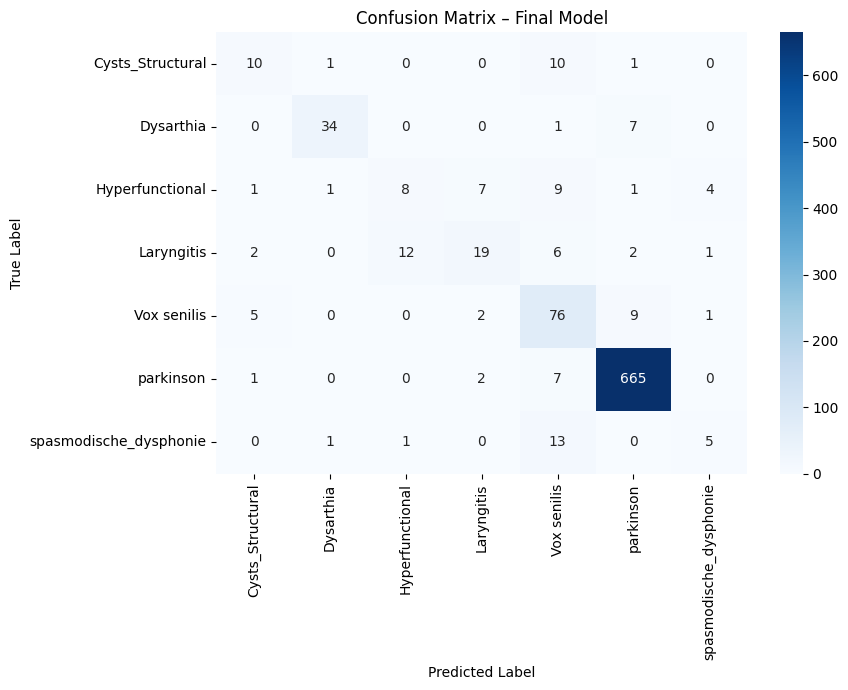

In [20]:
# ================= FINAL TEST CELL =================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def test_final_model():
    print("\n🧪 Loading TEST dataset...")
    test_ds = DualStreamDataset("test")
    test_loader = DataLoader(
        test_ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    print("📦 Loading FINAL model checkpoint...")
    checkpoint = torch.load(
        "best_model_final.pth",
        map_location=CONFIG["device"],
        weights_only=False   # PyTorch 2.6+
    )

    model = DualStreamTransformer(len(CLASSES)).to(CONFIG["device"])
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    all_preds = []
    all_labels = []

    print("🔍 Running inference...")
    with torch.no_grad():
        for ssl, sfm, mask, labels in test_loader:
            ssl, sfm, mask = (
                ssl.to(CONFIG["device"]),
                sfm.to(CONFIG["device"]),
                mask.to(CONFIG["device"])
            )

            logits, _ = model(ssl, sfm, mask)
            preds = logits.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ---------- METRICS ----------
    acc = (all_preds == all_labels).mean() * 100
    print(f"\n✅ Test Accuracy: {acc:.2f}%\n")

    print("📊 Classification Report:\n")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        digits=4
    ))

    # ---------- CONFUSION MATRIX ----------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASSES,
        yticklabels=CLASSES
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – Final Model")
    plt.tight_layout()
    plt.show()

    return acc, cm


# ================= RUN =================
final_test_acc, final_test_cm = test_final_model()
